In [ ]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime
import yfinance as yf
yf.pdr_override()

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [ ]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [ ]:
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2023, 1, 1)

tickers = ['BAC', 'JPM', 'USB', 'C', 'WFC', 'PNC', 'SCHW', 'MS', 'GS', 'TFC', 'IBN']
df = pdr.get_data_yahoo(tickers, start, end)['Close']

[*********************100%%**********************]  11 of 11 completed


[('BAC', 'PNC'), ('GS', 'MS'), ('GS', 'SCHW'), ('MS', 'SCHW')]


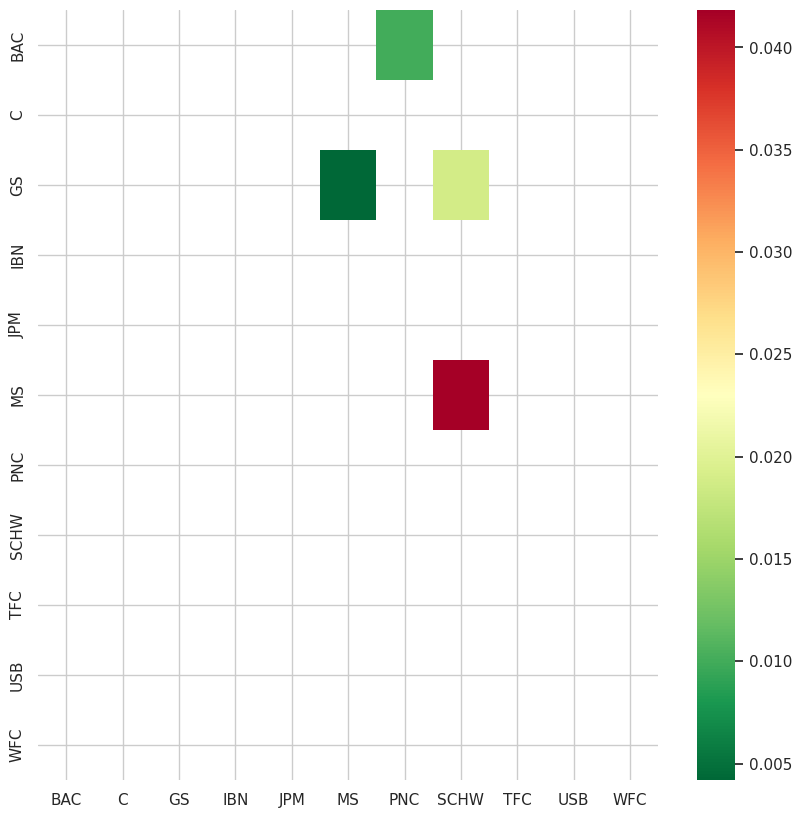

In [ ]:
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap
scores, pvalues, pairs = find_cointegrated_pairs(df)
import seaborn
fig, ax = plt.subplots(figsize=(10,10))
seaborn.heatmap(pvalues, xticklabels=df.columns, yticklabels=df.columns, cmap='RdYlGn_r', mask = (pvalues >= 0.05))
print(pairs)

In [ ]:
S1 = df['PNC']
S2 = df['BAC']

score, pvalue, _ = coint(S1, S2)
pvalue

0.008763831668904168

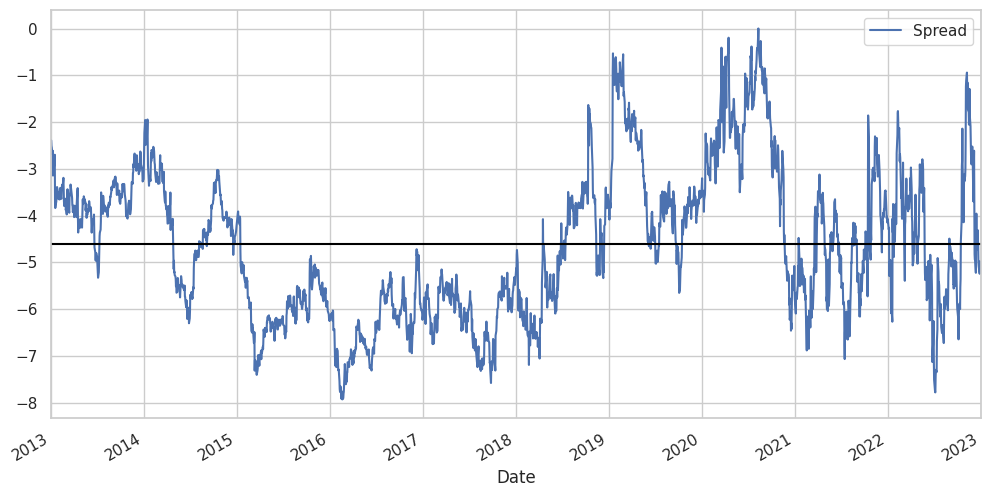

In [ ]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['PNC']
b = results.params['PNC']

spread = S2 - b * S1
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(), color='black')
plt.xlim('2013-01-01', '2023-01-01')
plt.legend(['Spread']);

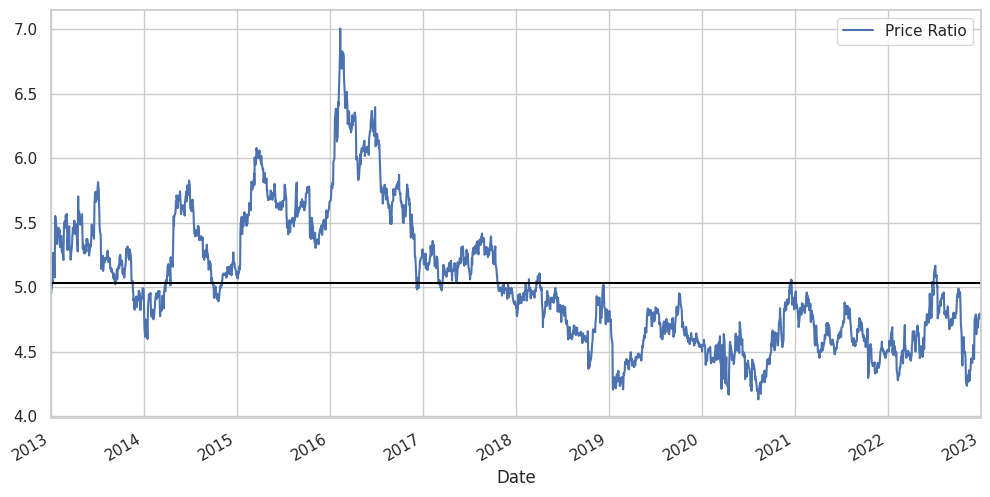

In [ ]:
ratio = S1/S2
ratio.plot(figsize=(12,6))
plt.axhline(ratio.mean(), color='black')
plt.xlim('2013-01-01', '2023-01-01')
plt.legend(['Price Ratio']);

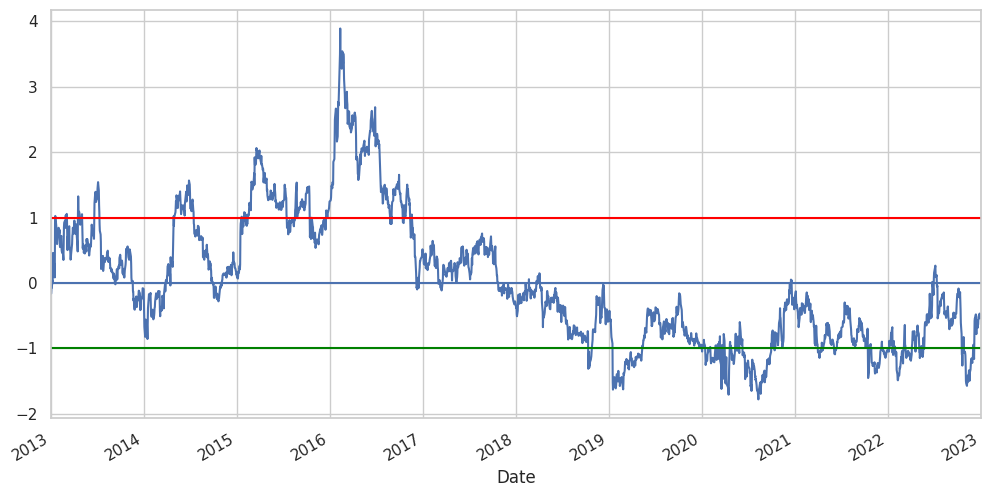

In [ ]:
def zscore(series):
    return (series - series.mean()) / np.std(series)


zscore(ratio).plot(figsize=(12,6))
plt.axhline(zscore(ratio).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.xlim('2013-01-01', '2023-01-01')
plt.show()

In [ ]:
ratios = df['PNC'] / df['BAC']
print(len(ratios) * .80 )

2014.4


In [ ]:
train = ratios[:1762]
test = ratios[1762:]

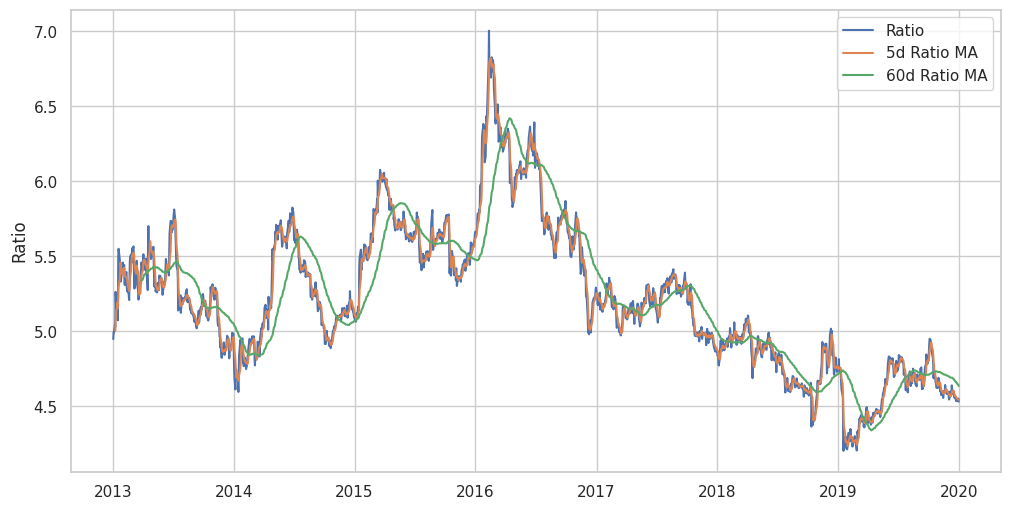

In [ ]:
ratios_mavg5 = train.rolling(window=5, center=False).mean()
ratios_mavg60 = train.rolling(window=60, center=False).mean()
std_60 = train.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

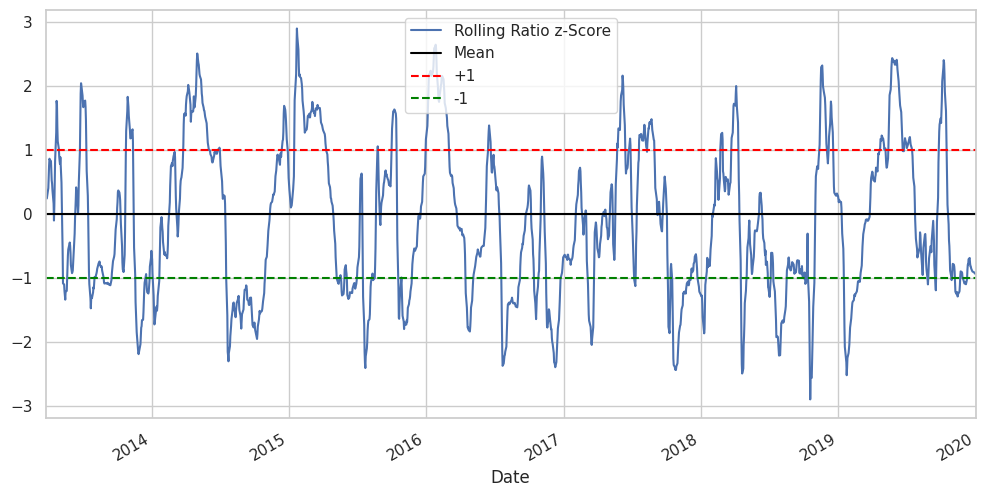

In [ ]:
plt.figure(figsize=(12,6))
zscore_60_5.plot()
plt.xlim('2013-03-25', '2020-01-01')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

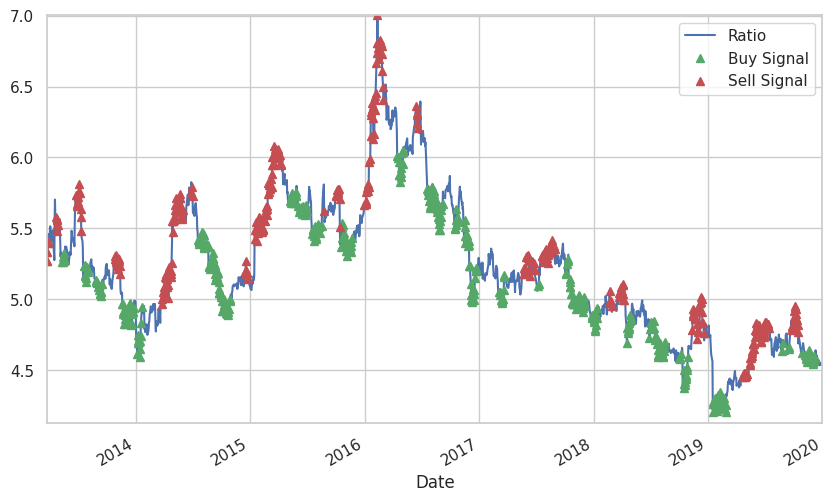

In [ ]:
plt.figure(figsize=(10,6))

train.plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy.plot(color='g', linestyle='None', marker='^')
sell.plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratios.min(), ratios.max()))
plt.xlim('2013-03-25','2020-01-01')
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

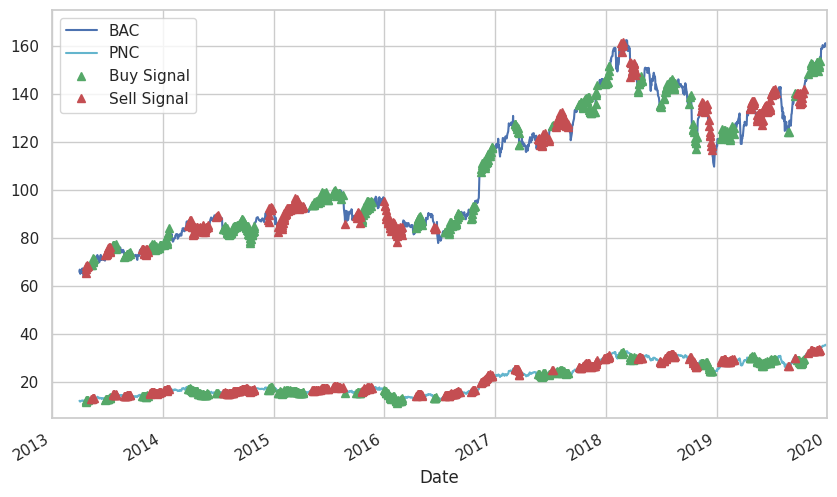

In [ ]:
plt.figure(figsize=(10,6))
S1 = df['PNC'].iloc[:1762]
S2 = df['BAC'].iloc[:1762]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))
plt.ylim(5, 175)
plt.xlim('2013-01-01', '2020-01-01')

plt.legend(['BAC', 'PNC', 'Buy Signal', 'Sell Signal'])
plt.show()

In [ ]:
# @title
def trade(S1, S2, window1, window2, silence=False, z=1, s=0.75):
    if (window1 == 0) or (window2 == 0):
        return 0
    if window1 >= window2:
      return -20
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1, center=False).mean()
    ma2 = ratios.rolling(window=window2, center=False).mean()
    std = ratios.rolling(window=window2, center=False).std()
    zscore = (ma1 - ma2)/std
    closing_total = []
    running_average = 0
    initial = 10000
    money = 10000
    countS1 = 0
    countS2 = 0
    prev = 0
    for i in range(len(ratios)):
        if zscore[i] > z:
            money += (S1[i] - S2[i] * ratios[i])
            countS1 -= 1
            countS2 += ratios[i]
        elif zscore[i] < -z:
            money -= (S1[i] - S2[i] * ratios[i])
            countS1 += 1
            countS2 -= ratios[i]
        elif abs(zscore[i]) < s:
            money += (S1[i] * countS1 + S2[i] * countS2)
            countS1 = 0
            countS2 = 0
        closing_total += [money]
        running_average += money
        prev = money

    running_average = running_average/len(ratios)
    Standard_difference = 0
    for i in closing_total:
      Standard_difference += (i - running_average) ** 2
    StandD = (Standard_difference / len(ratios))**(1/2)
    if not StandD:
      return -20

    total_return = money - initial
    sharpe = ((total_return) - (initial*(1+0.04273)**3 - initial))/StandD

    if not silence:
      print("Standard Deviation: ", StandD)
      print("initial holdings: ", initial)
      print("end portfolio value: ", money)
      print("total return: ", total_return)
      print("Sharpe: ", sharpe)
      pd.Series(closing_total, index=S1.index).plot()
    if sharpe is None:
      return 0
    return sharpe

In [ ]:
!pip install pygad
import pygad

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:748: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resulted in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(f"The percentage of genes to mutate (mutation_percent_genes={mutation_percent_genes}) resulted in selecting ({mutation_num_genes}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.")
/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause t

Parameters of the best solution : [34 188 0.7669893691018488 0.15]
Fitness value of the best solution = 5.47323546665405
Standard Deviation:  1226.7962517877434
initial holdings:  10000
end portfolio value:  14283.312576482793
total return:  4283.312576482793
Sharpe:  2.4012600285057832


2.4012600285057832

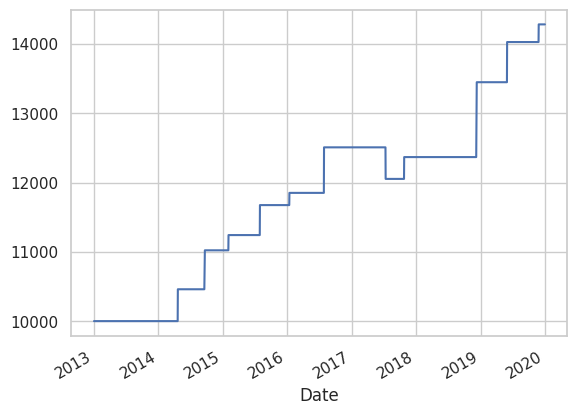

In [ ]:
# Genetic algorithm for testing parameters

def fitness_func(ga_instance, solution, solution_idx):
  return np.sinh(trade(df['PNC'].iloc[:1762], df['BAC'].iloc[:1762], solution[0], solution[1], z=solution[2], s=solution[3], silence=True))

fitness_function = fitness_func

num_generations = 50
num_parents_mating = 4

sol_per_pop = 8
num_genes = 4

init_range_low = 1
init_range_high = 300

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 10

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_type=[int, int, float, float],
                       gene_space=[range(3, 50), range(20, 200), {'low': 0.75, 'high': 3}, {'low': 0.15, 'high': 0.75}]
                       )

ga_instance.run()

solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

trade(df['PNC'].iloc[:1762], df['BAC'].iloc[:1762], solution[0], solution[1], z=solution[2], s=solution[3])

including 2020 (2020-2023)
Standard Deviation:  805.7050921388311
initial holdings:  10000
end portfolio value:  12918.734645607672
total return:  2918.734645607672
Sharpe:  1.962602554075746

exlcuding 2020 (2021-2023)
Standard Deviation:  454.0394233130367
initial holdings:  10000
end portfolio value:  11703.137532693754
total return:  1703.137532693754
Sharpe:  0.8053964919637991

whole frame (2013-2023)
Standard Deviation:  2136.6763003135125
initial holdings:  10000
end portfolio value:  17952.70917946252
total return:  7952.709179462519
Sharpe:  3.0960484770424523


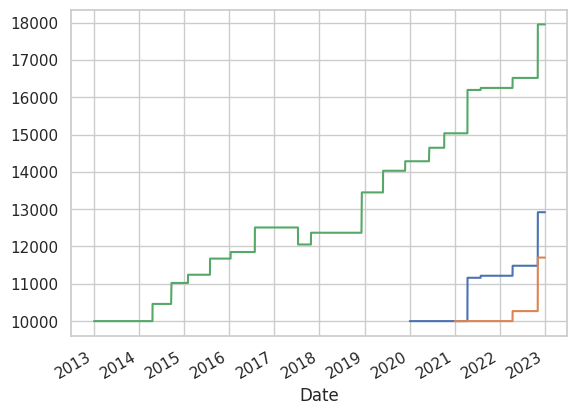

In [ ]:
incl_2020 = int(len(ratios) * 0.7)
excl_2020 = int(len(ratios) * 0.8)
whole_frame = 1

windows = solution

print('including 2020 (2020-2023)')
profit = trade(df['PNC'].iloc[incl_2020:], df['BAC'].iloc[incl_2020:], windows[0], windows[1], z=windows[2], s=windows[3])

print('\nexlcuding 2020 (2021-2023)')
profit = trade(df['PNC'].iloc[excl_2020:], df['BAC'].iloc[excl_2020:], windows[0], windows[1], z=windows[2], s=windows[3])

print('\nwhole frame (2013-2023)')
profit = trade(df['PNC'].iloc[whole_frame:], df['BAC'].iloc[whole_frame:], windows[0], windows[1], z=windows[2], s=windows[3])
